# Fiber Ports

[Ports](Ports.ipynb) are the used in PhotonForge to represent connections that use waveguides constructed from a [technology](Technology.ipynb)'s layers and extrusion profiles.
[Fiber ports](../_autosummary/photonforge.FiberPort.rst) are used to create similar connections via waveguides outside the technology's specifications, such as an optical fiber, which is the most common use of this class, hence its name.

This type of port is specified in 3D space by a position and an input vector, similarly to a [Gaussian port](../_autosummary/photonforge.GaussianPort.rst).
It also requires the specification of it cross-sectional geometry from planar structures and the media they represent.
These structures have no representation in the component layout, so they are not [exported](Layout_Export.ipynb) to GDSII or OASIS files, for example.

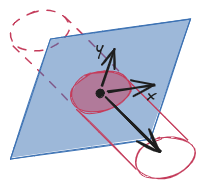

In [1]:
import photonforge as pf
import tidy3d as td
import numpy as np

tech = pf.basic_technology()
pf.config.default_technology = tech

## Port Cross-Section

The [cross-section](../_autosummary/photonforge.FiberPort.rst#photonforge.FiberPort.cross_section) of a fiber port is described by a list of planar [structures](../structures.rst#d-structures) and the media associated to them once the cross-section is extruded into a 3D waveguide. As a simple example, we can create a conventional single-mode optical fiber as follows.
Note that the port size is considerably smaller than the full fiber cladding region, because it is only large enough to support the mode confined in the core region.
Furthermore, the core is sligthly non-circular to help with the LP mode orientations.

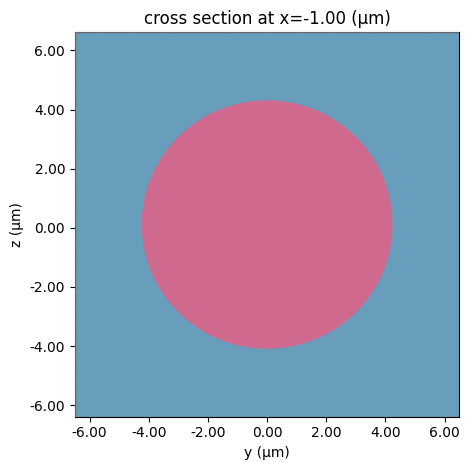

In [2]:
fiber_port = pf.FiberPort(
    center=(-1, 0, 0.11),
    input_vector=(1, 0, 0),
    size=(13, 13),
    extrusion_limits=(-100, 1),
    cross_section=[
        (pf.Circle(62.5), td.Medium(permittivity=1.445**2)),
        (pf.Circle((4.24, 4.2)), td.Medium(permittivity=1.46**2)),
    ],
    num_modes=1,
    target_neff=1.46,
)

_ = pf.tidy3d_plot(fiber_port)

Similarly to [Port](../_autosummary/photonforge.Port.rst) instances, we can export a mode solver to inspect the fiber port's modes or compute the modes directly with the [port_modes](../_autosummary/photonforge.port_modes.rst) function.

Loading cached simulation from .tidy3d/pf_cache/PAU/ms_info-JR5P2NARHB7DFZQYB3YCC26QWEFXPHOXAT7YKJBDO77AMFXUQUMQ.json.


wavelength    n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                 
1.934145e+14 0                 1.55  1.45594    0.0          0.999998   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                 0.998013        0.997799  47.047959

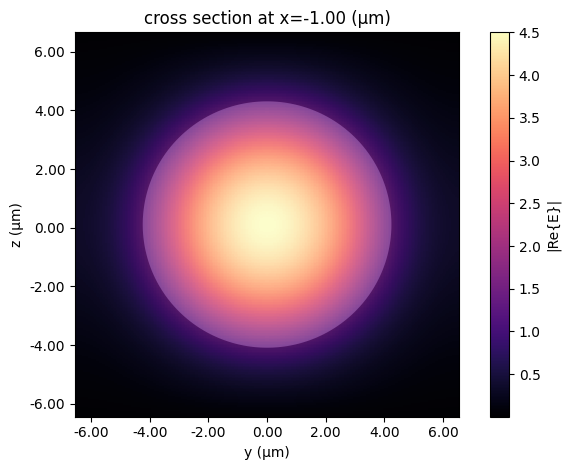

In [3]:
freqs = [pf.C_0 / 1.55]

mode_solver = pf.port_modes(fiber_port, freqs)
mode_solver.plot_field("E", mode_index=0, f=freqs[0], robust=False)
mode_solver.data.to_dataframe()

The fiber cross-section is always centered around the origin.
The origin is placed at the port's center normal to its input vector, which is the extrusion direction of the waveguide.
The extrusion extends behind and in front of the cross-section plane according to the `extrusion_limits`.

We can show that by adding the port to a component, in this case, an inverse taper with parabolic profile.
First we see that the component layout does not include any geometry from the fiber port:

In [4]:
taper_length = 20
taper_tip = 0.1
taper_width = pf.Expression(
    "u",
    [
        ("w0", taper_tip),
        ("dw", 0.5 - taper_tip),
        ("width", "w0 + dw * u^2"),
        ("derivative", "dw * 2 * u"),
    ],
)

taper = pf.Component("TAPER")

# Taper geometry
taper.add(
    "WG_CORE",
    pf.Path((0, 0), taper_tip)
    .segment((taper_length, 0), taper_width),
    "WG_CLAD",
    pf.stencil.linear_taper(widths=(9, 3), length=taper_length),
)

# Ports
taper.add_port(pf.Port((taper_length, 0), 180, "Strip"), "P0")
taper.add_port(fiber_port, "P1")

taper

With the [tidy3d_plot](../_autosummary/photonforge.tidy3d_plot.rst) utility we can quickly inspect the extruded geometry and see the fiber port in full:

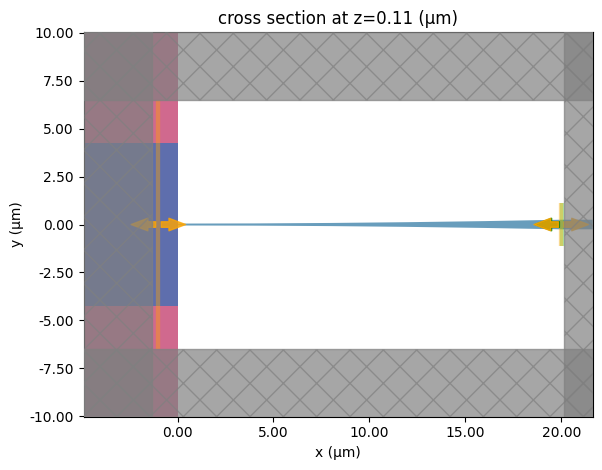

In [5]:
_ = pf.tidy3d_plot(taper, z=0.11)

We can evaluate the coupling by computing the component's [S parameters](S_Parameters.ipynb) with a [Tidy3D model](Tidy3D_Model.ipynb).
Note the use of symmetry to force the correct fiber mode from the degenerate pair of LP fiber modes.

Loading cached simulation from .tidy3d/pf_cache/3YT/fdtd_info-2NWU6G7KWYSGZNRYB5UOQNJE6FGAC7BZ5IT6ZQOOXIDAL7P6F46A.json.


Loading cached simulation from .tidy3d/pf_cache/3YT/ms_info-NNXYNEP3DWWUOTKEPOISQZXJEGYCTWFIGJXQDSVTLR2ISLNOUMLQ.json.
Loading cached simulation from .tidy3d/pf_cache/3YT/ms_info-J2AVDAWQ6Y2S2MGUQYOGPDS5WW7BAYRFVPR3ORUAABVNGQNGWUJA.json.
Progress: 100% 


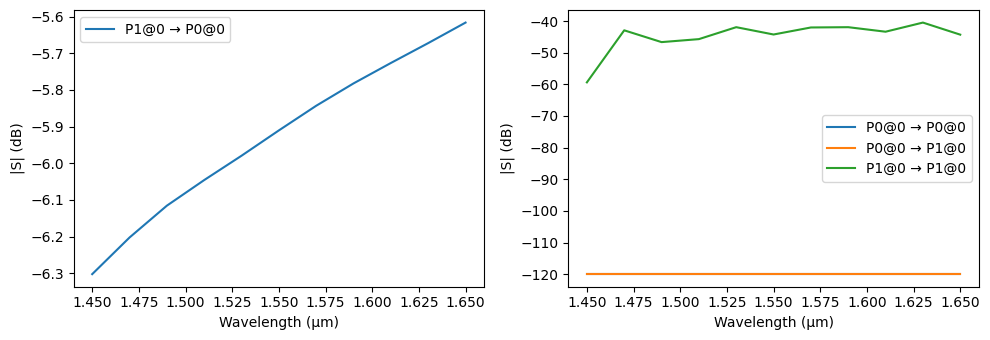

In [6]:
taper.add_model(pf.Tidy3DModel(symmetry=(0, -1, 0)), "Tidy3D")

s = taper.s_matrix(pf.C_0 / np.linspace(1.45, 1.65, 11), model_kwargs={"inputs": ["P1"]})
_ = pf.plot_s_matrix(s, y="dB")

As an example of simple analysis, we can check the effect in the coupling once the fiber is tilted by 2° downwards (lateral rotations have to be accompanied by a removal of the symmetry plane).
The mode solver will find non-physical modes when the angle is included, so we add another mode to it, to make sure we find the correct one.

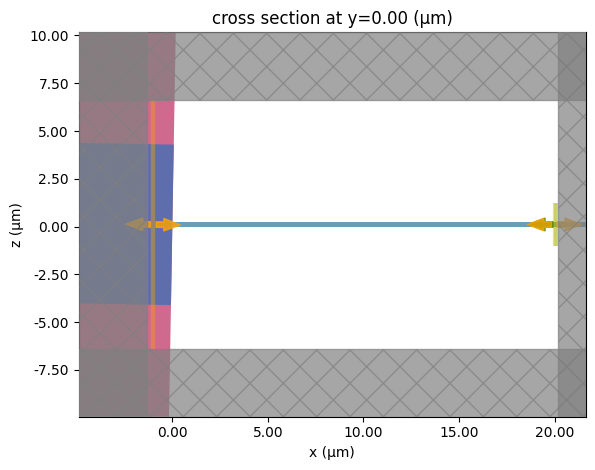

In [7]:
angle = -1 * np.pi / 180.0
fiber_port.input_vector = (np.cos(angle), 0, np.sin(angle))
fiber_port.num_modes = 2

_ = pf.tidy3d_plot(taper, y=0)

Loading cached simulation from .tidy3d/pf_cache/3YT/fdtd_info-O6VJI2J75VTFTL2LBUGP3G7TVJE3RCTVO4UX77A3TFIS5NLRZYMA.json.


Loading cached simulation from .tidy3d/pf_cache/3YT/fdtd_info-O6TEOYEVAZSL3DYYAKBIXXPI4I4MEKSRPSD2J2IM4B3FVYKGUEQQ.json.
Loading cached simulation from .tidy3d/pf_cache/3YT/ms_info-J73IHIOFK6MONQFNPYZRYPXRJKZ64QTZIXC24O4Q7K622MIHODTA.json.
Loading cached simulation from .tidy3d/pf_cache/3YT/ms_info-YBJOB3557U7TBUW3QURRVWK6OGPXYZFLIJLA27JLNIQ2FTHELTQA.json.


Progress: 100% 


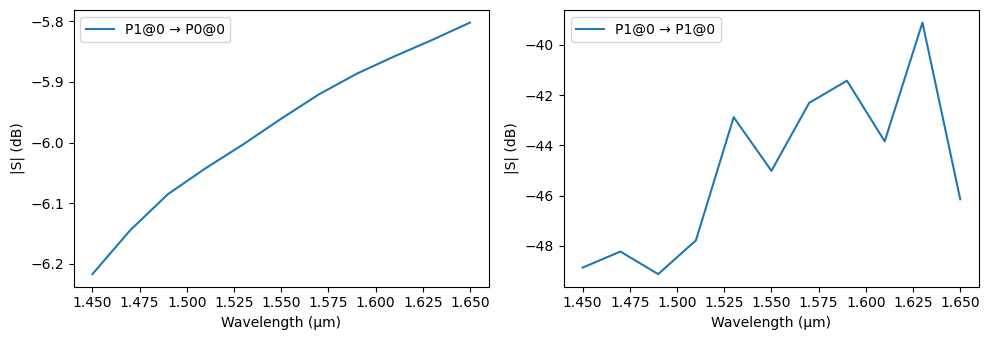

In [8]:
s = taper.s_matrix(pf.C_0 / np.linspace(1.45, 1.65, 11), model_kwargs={"inputs": ["P1"]})
_ = pf.plot_s_matrix(s, y="dB", input_ports=["P1"])